In [1]:
import os
import random
import torch
import importlib
import src.util as util
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 


In [2]:
path=os.getcwd()
path

'/media/data/home/darcy/master_summary'

In [3]:
file=pd.read_csv(path+'/datasets/air_quality_processed.csv')
file.info()
file=file.drop(columns=['Date','Time'])

data=(file-file[:7154].min())/(file[:7154].max()-file[:7154].min())
scale=[file[:7154].max().tolist(),file.min()[:7154].tolist()]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 11 columns):
Date             9357 non-null object
Time             9357 non-null object
PT08.S1(CO)      9005 non-null float64
C6H6(GT)         9005 non-null float64
PT08.S2(NMHC)    9005 non-null float64
PT08.S3(NOx)     9005 non-null float64
PT08.S4(NO2)     9005 non-null float64
PT08.S5(O3)      9005 non-null float64
T                9005 non-null float64
RH               9005 non-null float64
AH               9005 non-null float64
dtypes: float64(9), object(2)
memory usage: 804.2+ KB


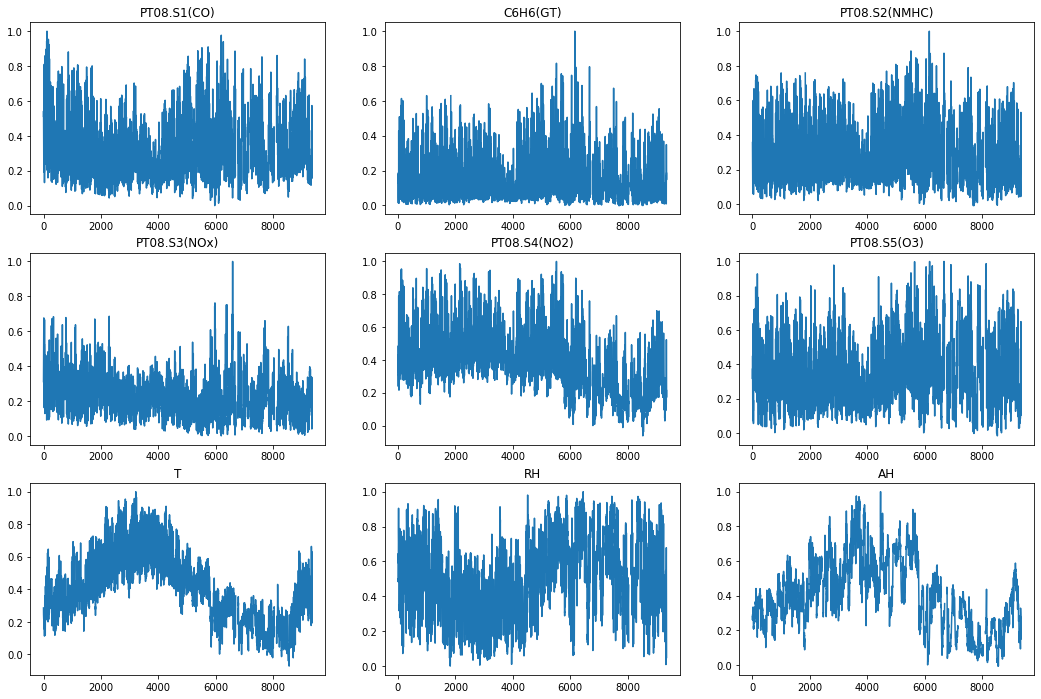

In [5]:
plt.figure(figsize=(18,12))
for i in range(len(data.columns)):
    plt.subplot(331+i)
    plt.plot(data[data.columns[i]])
    plt.title(data.columns[i])
#plt.legend(data.columns,loc='upper left')

In [4]:
cut_points=[0,701,725,1825,1839,2420,2458,4044,4089,4349,4368,6695,6770,7155,7207,7775,7784,8039,8115,9358]
len(cut_points)
count=0
pieces=[]
for i in range(0,20,2):
    pieces.append(data.iloc[cut_points[i]:cut_points[i+1]])
    count+=len(pieces[-1])
print(count)

9005


# generate inputs and outputs

In [5]:
def make_neighbor_list(target, input_dim):
    neighbors=[target]
    for i in range(input_dim):
        if i == target:
            continue
        else:
            neighbors.append(i)

    return neighbors

    
def make_io(input_len,output_len,neighbors,shuffle=True): #neighbors is a list 
    dataset1=[] #training dataset
    dataset2=[] #testing dataset
    package1=[[],[],[]]
    package2=[[],[],[]]
   
    
    for n in range(10):
        data1=pieces[n].values
        data_len=data1.shape[0]
        data_dim=data1.shape[1]
        for j in range(data_len-input_len-output_len):
            one_x=[]
            one_y=[]
            i=neighbors[0]
            s=[scale[0][i],scale[1][i]]
            for k in neighbors:
                    one_x.append(data1[j:j+input_len,k].reshape(input_len,-1))
                    one_y.append(data1[j+input_len:j+input_len+output_len,k].reshape(output_len,-1))
                
            one_x=np.concatenate(one_x,axis=1)
            one_y=np.concatenate(one_y,axis=1)
            one_data=[one_x.tolist(),one_y.tolist(),s]
            
            if n<7:
                dataset1.append(one_data)
            else:
                dataset2.append(one_data)
    if shuffle:
        random.shuffle(dataset1)
        random.shuffle(dataset2)
   
    for i in range(len(dataset1)):
        package1[0].append(dataset1[i][0])
        package1[1].append(dataset1[i][1])
        package1[2].append(dataset1[i][2])
    
    for i in range(len(dataset2)):
        package2[0].append(dataset2[i][0])
        package2[1].append(dataset2[i][1])
        package2[2].append(dataset2[i][2])
    #return dataset1,dataset2

    return package1, package2


# training function 

In [6]:
def train(inputs, epochs, input_dim, input_len, output_len, model, loss_func, constrain=False):
    
    testing_mae=0
    testing_mape=0
    
    target=inputs[0]
    print(data.columns[target])
    
    
    dataset1,dataset2=make_io(input_len,output_len,inputs)
    dataset3,dataset4=make_io(input_len,output_len,inputs,False)

    X_train=torch.FloatTensor(dataset1[0])
    Y_train=torch.FloatTensor(dataset1[1])[:,:,0].unsqueeze(2)
    S_train=torch.FloatTensor(dataset1[2])

    X_test=torch.FloatTensor(dataset2[0])
    Y_test=torch.FloatTensor(dataset2[1])[:,:,0].unsqueeze(2)
    S_test=torch.FloatTensor(dataset2[2])

    X_train_valid=torch.FloatTensor(dataset3[0])
    Y_train_valid=torch.FloatTensor(dataset3[1])[:,:,0].unsqueeze(2)
    S_train_valid=torch.FloatTensor(dataset3[2])

    X_test_valid=torch.FloatTensor(dataset4[0])
    Y_test_valid=torch.FloatTensor(dataset4[1])[:,:,0].unsqueeze(2)
    S_test_valid=torch.FloatTensor(dataset4[2])
        
    model.to(gpu) #model放到gpu裡
    print('number of parmeters:', util.count_parameters(model))
    
    for j in range(epochs):
        if j<500:
            rate=0.001
        elif j>500 and j<2000:
            rate=0.0001
        else:
            rate=0.00001
            
        opt=torch.optim.Adam(model.parameters(),lr=rate)
        
        if constrain:
            model.weight.data.clamp_(0,1)
  
        #compute_loss(model, feature, label, batch, opt, train, loss_func, device)
        training_loss=util.compute_loss(model, X_train, Y_train, batch, opt, loss_func, train=True,device=gpu)
        testing_loss=util.compute_loss(model,X_test,Y_test,batch,opt, loss_func, train=False,device=gpu)
        test_mape=util.mape(model(X_test.to(gpu))[:,:,0].to(cpu),Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
        
        if j%100==0:
            print('epoch:'+str(j))
            print('training mae loss:'+str(training_loss))
            print('testing mae loss:'+str(testing_loss))
            print('testing mape:'+str(test_mape))
            if constrain:
                print(model.weight.data)
    
    
    model.to(cpu)   
     # plot_result(model, xs, ys, output_len, title, target_series, scale, save_path)
    util.plot_result(model, [X_train_valid,X_test_valid],[Y_train_valid,Y_test_valid],output_len,data.columns[target], target, 
                     scale, path+ '/results/plots/air_quality/')
    
    #plt.savefig(path+ '/results/plots/exchange_rate/'+data.columns[target]+'_prediction.png')
    #plt.clf()
    #    testing_mae+=testing_loss
    #    testing_mape+=mape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
    
   
    return X_train_valid, X_test_valid
    

# Set gpu and loss function

In [7]:
objective=torch.nn.L1Loss()
gpu = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(gpu)
cpu=torch.device('cpu')

cuda:0


# train model

S2S_cnn_attn(
  (encoder): Encoder(
    (pooling): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    (convs): ModuleList(
      (0): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (1): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (2): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (3): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (4): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (5): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (6): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (7): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
      (8): Conv1d(1, 4, kernel_size=(4,), stride=(1,))
    )
  )
  (decoder): Decoder(
    (rnn): GRU(1, 80, batch_first=True)
    (fc1): Linear(in_features=80, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=1, bias=True)
  )
)
PT08.S4(NO2)
number of parmeters: 21413
epoch:0
training mae loss:0.2759817987680435
testing mae loss:0.10729032009840012
testing mape:0.21862623
epoch:100
training mae loss

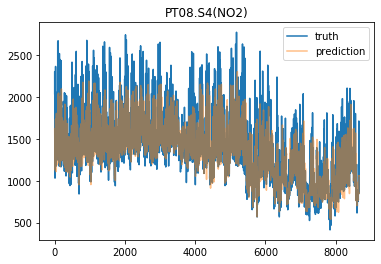

<Figure size 432x288 with 0 Axes>

In [23]:
import src.model

targets=[4]
input_dim=9
cnn_hidden_size=4
cnn_kernel_size=4
cnn_parameters=(cnn_hidden_size,cnn_kernel_size)
fc_size=16
input_length=24
output_length=12

split=2000
num_epochs=5000
batch=5000

#attention_weights=[]

for i in targets:
    
    inputs=make_neighbor_list(i, input_dim)
    
    model=src.model.S2S_cnn_attn(cnn_parameters,fc_size,input_dim,input_length,output_length)
    print(model)
    
    X_train,X_test=train(inputs,num_epochs,input_dim, input_length, output_length, model, objective)
    
    torch.save(model, path+ '/results/models/'+data.columns[i]+'.pt')
    #attention_weights.append(attns)

# show results

In [18]:
i=3
file_name=data.columns[i]
model=torch.load(path+ '/results/models/'+file_name+'.pt')

In [19]:
inputs=make_neighbor_list(target=i, input_dim=9)

#make_io(input_len,output_len,neighbors,shuffle=True)
dataset1, dataset2=make_io(input_len=24,output_len=12,neighbors=inputs, shuffle=False)
X_train=torch.FloatTensor(dataset1[0])
X_test=torch.FloatTensor(dataset2[0])
Y_test=torch.FloatTensor(dataset2[1])[:,:,0].unsqueeze(2)

test_mae=util.mae(model(X_test)[:,:,0],Y_test[:,:,0])
print(test_mae)
test_mape=util.mape(model(X_test)[:,:,0],Y_test[:,:,0],(scale[0][i]-scale[1][i]),scale[1][i])
print(test_mape)

0.047664955
0.14962812


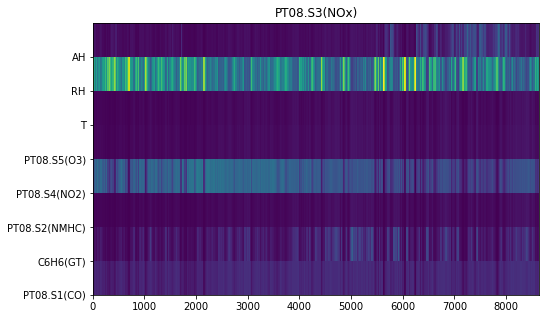

[[0.028655581176280975,
  0.001974688610062003,
  0.0007252321811392903,
  0.06892790645360947,
  0.0014292385894805193,
  0.0007252321811392903,
  0.8910883665084839,
  0.006473741959780455],
 [0.02873515710234642,
  0.002009876538068056,
  0.0007386934594251215,
  0.07003971189260483,
  0.0014448062283918262,
  0.0007386934594251215,
  0.8898800015449524,
  0.006413089577108622],
 [0.02879197522997856,
  0.002116393530741334,
  0.0007576924981549382,
  0.07253461331129074,
  0.0014914288185536861,
  0.0007576924981549382,
  0.8871410489082336,
  0.00640908582136035],
 [0.02931820973753929,
  0.002316452097147703,
  0.0007844909559935331,
  0.07498716562986374,
  0.0015820356784388423,
  0.0007844909559935331,
  0.8838019371032715,
  0.006425250321626663],
 [0.031570304185152054,
  0.0027734560426324606,
  0.0008867562864907086,
  0.08189846575260162,
  0.0018275479087606072,
  0.0008867562864907086,
  0.8732100129127502,
  0.006946715526282787],
 [0.03530445322394371,
  0.00351344887

<Figure size 432x288 with 0 Axes>

In [20]:
attns= util.plot_attention(model, X_train, X_test, data.columns, inputs, path+ '/results/plots/exchange_rate/')
attns